In [24]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
import scipy.optimize as opt
import os
import sys
from matplotlib import mlab,cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

%matplotlib inline
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.borderpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 18
mpl.rcParams['legend.numpoints'] = 1
plt.rc('lines', linewidth=3)
color_cyc = ['4D4D4D','5DA5DA', 'FAA43A', '60BD68', 'F17CB0','B2912F','B276B2','DECF3F','F15854']
                                #  (blue)
                                # (orange)
                                # (green)
                                # (pink)
                                #  (brown)
                                # (purple)
                                #  (yellow)
                                # (red)
                                # ']
mpl.rcParams['axes.color_cycle'] = color_cyc

# Function Definitions

In [25]:
def st_solver(st=1,alph = 1e-100,a_au=1,m_suns=1,m_earths=1,verbose=0,smooth=1,gas_dep=1.,sig_in = 0, temp_in = 0):

    if verbose:
        print "St = %.7g" %st
        print "a = %.3g AU" %a_au
        print "m_star = %.3g m_sun" %m_suns
        print "m_core = %.3g m_earths" %m_earths

    a_core = fn.au*a_au
    m_star = fn.m_sun*m_suns
    r_core = fn.r_earth*((m_earths)**(1./3.))
    m_core = fn.m_earth*m_earths

    rho_obj = 2.0

    if sig_in:
        sig = sig_in
    else:
        sig = fn.surf_dens(a_core)

    if temp_in:
        t = temp_in
    else:
        t =  fn.temp(a_core)

    #Return derived parameters
    # sig = fn.surf_dens(a_core)/gas_dep
    # t =  fn.temp(a_core)
    om = fn.omega(m_star,a_core)
    cs = fn.sound_speed(t)
    h = fn.scale_height(cs,om)
    rho_g = fn.gas_density(sig,h)
    mfp = fn.mean_free_path(fn.mu,rho_g,fn.cross)
    vth = fn.therm_vel(cs)
    v_core = fn.vkep(m_star,a_core)
    vg = fn.v_gas(v_core,cs)
    vkep = v_core
    v_cg = np.absolute(v_core - vg)
    vrel_i = v_cg
    v_g_phi = v_cg
    eta = fn.eta(cs,vkep)

    #Build array of Hill Radii
    h_r = fn.hill_rad(m_core,a_core,m_star)
    # h_r_arr.fill(fn.hill_rad(m_core,a_core,m_star))

    #Build array of Bondi Radii
    # b_rad_arr = np.zeros(pnts)
    b_r = fn.bondi_rad(m_core,cs)
    # b_rad_arr.fill(fn.bondi_rad(m_core,cs))
    b_rad = fn.bondi_rad(m_core,cs)

    if verbose:
        print "sig = %s" %sig
        print "T = %s" %t
        print "om = %s" %om
        print "cs = %s" %cs
        print "H = %s" %h
        print "rho_g = %s" %rho_g
        print "mfp = %s" %mfp
        print "vth = %s" %vth
        print "v_cg = %s\n" %v_cg

    r_eps = st*rho_g/rho_obj*vth/om

    if verbose:
        print "r_eps = %.5g" %r_eps

    if r_eps < 9.*mfp/4.:
        if verbose:
            print "Epstein Regime"
        return r_eps
    elif verbose:
        print "Not in Epstein"


    #Directly calculate v_rel from given St
    t_s = st/om
    if verbose:
        print "t_s = %.7g" %t_s

    # v_pg_L = np.sqrt(5)/2.*eta*vkep

    re_f = fn.re_f(alph,cs,h,vth,mfp)
    v_turb = np.sqrt(alph)*cs
    v_cg = np.sqrt(v_turb**2 + (vg-v_core)**2)
    v_gas_tot = np.sqrt(v_turb**2 + (vg-v_core)**2)

    # v_pg_L = eta*vkep*np.sqrt(1+4*st**2)/(1+st**2)
    v_pg_L = eta*vkep*st*np.sqrt(4.+st**2.)/(1+st**2.)
    t_eddy = om**(-1)/np.sqrt(1+v_pg_L**2/v_turb**2)

    stl = t_s/t_eddy
    v_pg_turb = fn.v_pg(v_turb,stl,re_f)

    v_pg_tot = np.sqrt(v_pg_turb**2 + v_pg_L**2)

    if verbose:
        print "Re_t = %.7g" %re_f
        print "t_eddy = %.7g" %(t_eddy*om)
        print "st_L = %.7g" %stl
        print "v_turb = %.7g" %v_turb
        print "v_gas_tot = %.7g" %v_gas_tot
        print "v_pg_L = %.7g" %v_pg_L
        print "v_pg_turb = %.7g" %v_pg_turb
        print "v_pg_tot = %.7g" %v_pg_tot

    # if smooth:
    def ts_zero(r,params):
        t_s = params[-1]
        return ts_sto_ram(r,params)-t_s

    params = [vth,mfp,rho_g,v_pg_tot,rho_obj,t_s]
    r_sto_ram = fsolve(ts_zero,9.*mfp/4.,args=params)[0]
    return r_sto_ram
    # else:
    #     re_sto = 6.*v_pg_tot*np.sqrt(st*rho_g/vth/mfp/rho_obj/om)
    #     re_RAM = 3.*st*v_pg_tot**2*rho_g/2./vth/mfp/rho_obj/om
    #
    #     if verbose:
    #         print "re_Sto = %.7g" %re_sto
    #         print "re_RAM = %.7g" %re_RAM

In [26]:
def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

In [27]:
def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st))[0]*st

In [28]:
def d_V_12(st_1=1.,st_2=1.,Re=1e8,v_gas=1.):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    
    st_eta = Re**(-0.5)
    
    st_1_str = st_str(st_1)
    st_2_str = st_str(st_2)
    
    st_12_str = max(st_1_str,st_2_str)
    st_12_str = max(st_12_str,st_eta)

    term_1 = (st_12_str + st_1**2./(st_1 + st_12_str) - (st_eta + st_1**2./(st_1 + st_eta))) +\
                ( (st_2 - st_1)/(st_1 + st_2) * (st_1**2./(st_1 + 1.) - st_1**2./(st_1 + st_12_str)) )

    term_2 = (st_12_str + st_2**2./(st_2 + st_12_str) - (st_eta + st_2**2./(st_2 + st_eta))) +\
                ( (st_1 - st_2)/(st_2 + st_1) * (st_2**2./(st_2 + 1.) - st_2**2./(st_2 + st_12_str)) )

    return np.sqrt(v_gas**2*(term_1 + term_2))

In [29]:
def v_pp(st_1 = 1., st_2 = 1., alpha = 1e-100, a_au = 1., m_suns = 1., T_0 = 270., T_exp = -3./7.,sig_0 = 2000.,\
        sig_exp = -1.,sol_gas_ratio = 100.,verbose=0):
    """Return the relative velocity between two particles of different sizes. Includes thermal motion,
    laminar velocity, and turbulent velocity"""

    #Initialize disk parameters. Temperature and Surface density are calculated from inputs to function
    T = T_0*a_au**T_exp
    cs = (fn.k*T/fn.mu)**(1./2.)
    
    om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
    vk = a_au*fn.au * om
    
    eta = cs**2./2./vk**2.
    v_gas_lam = eta*vk
    v_gas_turb = (alpha)**(1./2.)*cs
    
    sig_g = sig_0*a_au**sig_exp
    H_g = cs/om
    rho_g = sig_g/2./H_g

    vth = np.sqrt(8./np.pi)*cs
    mfp = fn.mu/rho_g/fn.cross
    
    
    if alpha < 1e-10: #d_V_12 produces nan if Re is too low. For low alpha raising Re slightly shouldn't cause errors
        Re_t = 10.
    else:
        Re_t = alpha*cs*H_g/vth/mfp
    
    if verbose:
        print "Re_t = %.5g" %Re_t

    rho_s = 2.
    
    #Solve for the radii of the particles from the Stokes numbers that were passed to the function
    r_1 = st_solver(st = st_1, a_au = a_au, m_suns = m_suns, temp_in = T, sig_in = sig_g)
    r_2 = st_solver(st = st_2, a_au = a_au, m_suns = m_suns, temp_in = T, sig_in = sig_g)
    
    #Masses of the two particles
    mu_1 = 4./3.*np.pi*(r_1/2.)**3.*rho_s
    mu_2 = 4./3.*np.pi*(r_2/2.)**3.*rho_s
    
    #Average relative velocity between two particles that follow a MB distribution is the average velocity
    #of a MB distribution followed by a particle with mass equal to the reduced mass of the particles.
    mu_red = (mu_1*mu_2)/(mu_1 + mu_2)
    d_v_th = np.sqrt(8.*fn.k*T/np.pi/mu_red)

    
    #Calculate radial component of the two particles' Laminar velocity. Calculate \Delta v_r
    v_r_1 = -2*v_gas_lam*(st_1/(1+st_1**2.))
    v_r_2 = -2*v_gas_lam*(st_2/(1+st_2**2.))
    d_v_r = np.abs(v_r_1 - v_r_2)

    #Calculate radial component of the two particles' Laminar velocity. Calculate \Delta v_r
    v_theta_1 = -v_gas_lam*(1./(1+st_1**2.))
    v_theta_2 = -v_gas_lam*(1./(1+st_2**2.))
    d_v_theta = np.abs(v_theta_1 - v_theta_2)
    
    #Magnitude of relative velocity vector
    d_v_lam = np.sqrt(d_v_r**2. + d_v_theta**2.)
    
    #Relative turbulent velocity from OC07
    d_v_turb = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = v_gas_turb) #Added in line for turbulence


    d_v_tot = np.sqrt(d_v_th**2. + d_v_lam**2. + d_v_turb**2.) #Add all velocities in quadrature.
    #Not sure if this is really the correct way to combine all the velocities.
    
    if verbose:
        print "d_v_th = %.5g" %d_v_th
        print "d_v_lam = %.5g" %d_v_lam
        print "d_v_turb = %.5g" %d_v_turb

    return d_v_tot


In [62]:
def t_coll_int(r_s = 1.,st_min = 1e-4, st_max = 1.0, alpha = 1e-100, a_au = 1., m_suns = 1., T_0 = 270.,\
        T_exp = -3./7., sig_0 = 2000., sig_exp = -1.,sol_gas_ratio = 0.01,verbose=0, rho_s = 2.0,\
         rs_min_in = 0, rs_max_in = 0, int_pnts = 1000, gas_dep = 1.,out='time'):
    
    a_cgs = fn.au*a_au
    m_star = fn.m_sun*m_suns
    
    #Temperature from input parameters
    T = T_0*a_au**T_exp
    cs = (fn.k*T/fn.mu)**(1./2.)
    
    #Gas density
    sig_g =  sig_0*a_au**sig_exp
    sig_p = sig_g*sol_gas_ratio
    
    om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
    vk = a_au*fn.au * om
    
    eta = cs**2./2./vk**2.
    v_gas_lam = eta*vk
    v_gas_turb = (alpha)**(1./2.)*cs
    
    sig_g = sig_0*a_au**sig_exp
    H_g = cs/om
    rho_g = sig_g/2./H_g

    vth = np.sqrt(8./np.pi)*cs
    mfp = fn.mu/rho_g/fn.cross
    
    st = st_rad(rad=r_s,a_au=a_au,m_suns=m_suns,temp_in=T,sig_in=sig_g) #Can't handle gas_dep right now
    M = 4./3.*np.pi*r_s**3.*rho_s

    #Power law exponent for size distribution
    q = 3.5

    #Minimum and maximum sizes
    if rs_min_in:
        rs_min = rs_min_in
    else:
        rs_min = st_solver(st=st_min,a_au=a_au,m_suns=m_suns,gas_dep=gas_dep,temp_in=T,sig_in=sig_g)

    if rs_max_in:
        rs_max = rs_max_in
    else:
        rs_max = st_solver(st=st_max,a_au=a_au,m_suns=m_suns,gas_dep=gas_dep,temp_in=T,sig_in=sig_g)
        
    r_arr = np.logspace(np.log10(1.01*rs_min),np.log10(rs_max),num=int_pnts) 
        
    sum = 0
    for rad in r_arr:
        sum += rad**(-q+4) - rs_min**(-q+4)

    #Normalization constant for size distribution
    norm = sig_p/sum

    surf_dens_arr = norm*(r_arr**(-q+4)-rs_min**(-q+4))
    
#     print np.sum(surf_dens_arr)
    
    dM_dt = 0

    rate_arr = np.zeros(len(r_arr))

    for i,sig_p in enumerate(surf_dens_arr):
        r_int = r_arr[i]
        m_int = 4./3.*np.pi*r_int**3.*rho_s
        st_int = st_rad(rad=r_int,alph = alpha,a_au=a_au,m_suns=m_suns,sig_in = sig_g,temp_in = T)
        
        H_p_turb = (alpha/(alpha+st_int))*H_g
        H_p_lam = H_g**2./a_cgs
        H_p = max(H_p_lam,H_p_turb)
        n = sig_p/2./H_p/m_int
        
        sigma = np.pi*(r_int**2. + r_s**2.)
        v_rel = v_pp(st_1 = st, st_2 = st_int, alpha = alpha, a_au = a_au, m_suns = m_suns, T_0 = T_0,\
                     T_exp = T_exp,sig_0 = sig_0,sig_exp = sig_exp,sol_gas_ratio = sol_gas_ratio)
       
        rate = n*sigma*v_rel*m_int
        dM_dt += rate
        rate_arr[i] = rate
        
    if out=='arr':
        return M/dM_dt*fn.sec_to_years,rate_arr
    else:
        return M/dM_dt*fn.sec_to_years
        
        
        
    

# Check $\Delta V_{12}$ for real values

In [5]:
a_au = 1.
m_suns = 1.
r_1 = 1e-3

sol_gas_ratio = 100.

sig_g = 20000*(a_au)**(-1.)
sig_p = sig_g / sol_gas_ratio

T = 280*(a_au)**(-3./7.)
cs =  np.sqrt(fn.k*T/fn.mu)
vth = np.sqrt(8./np.pi)*cs
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
Hg = cs/om
rho_g = sig_g/2./Hg
mfp = fn.mu/rho_g/fn.cross

alphas = np.array([1e-4,1e-3,1e-2,1e-1])
r_2_arr = np.logspace(-5,5,num=1000)

st_1 = st_rad(rad=r_1,a_au = a_au, m_suns = m_suns)

v_12_arr = np.zeros((len(alphas),len(r_2_arr)))

for i,alph in enumerate(alphas):
    Re_t = alph*cs*Hg/(vth*mfp)
    v_gas = np.sqrt(alph)*cs
    for j,r_2 in enumerate(r_2_arr):
        st_2 = st_rad(rad=r_2,a_au = a_au, m_suns = m_suns) #This line pulls from my old code that gives St(radius)
        v_12_arr[i,j] = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = v_gas)


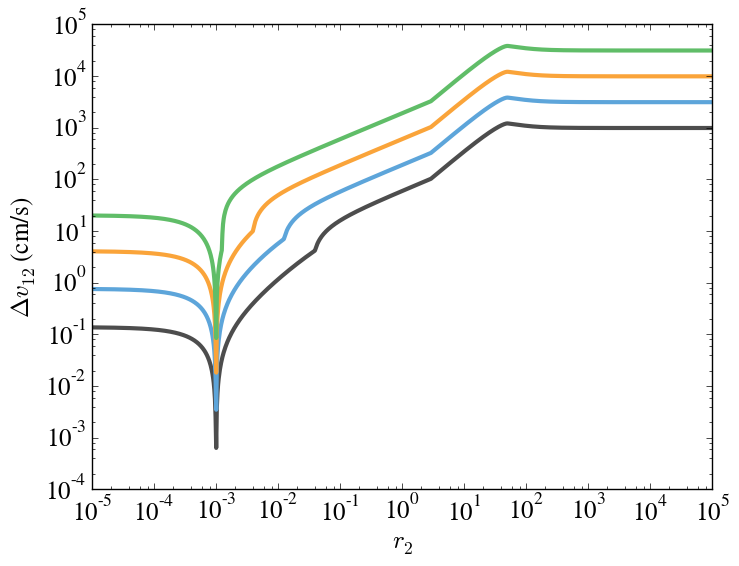

In [6]:
fig = plt.figure(1,figsize=(8,6))

for i in range(len(alphas)):
    plt.loglog(r_2_arr,v_12_arr[i])
    
plt.xlabel('$r_2$')
plt.ylabel('$\Delta v_{12}$ (cm/s)')

In [7]:
v_12_arr[0,0]

0.13721656119552539

# Check Contour Plot from Blum and Wurm

In [18]:
a_au = 1.
m_suns = 1.
T = 280*(a_au)**(-3./7.)
cs =  np.sqrt(fn.k*T/fn.mu)
vth = np.sqrt(8./np.pi)*cs
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
Hg = cs/om
rho_g = sig_g/2./Hg
mfp = fn.mu/rho_g/fn.cross

al = 0.010163442639908971
Re_t = al*cs*Hg/(vth*mfp)
v_gas = np.sqrt(al)*cs

r_1_arr = np.logspace(-4,4,num=500)
r_2_arr = np.logspace(-4,4,num=500)

v_12_arr = np.zeros((len(r_1_arr),len(r_2_arr)))

for i,r_1 in enumerate(r_1_arr):
    for j,r_2 in enumerate(r_2_arr):
        st_1 = st_rad(rad=r_1,a_au = a_au, m_suns = m_suns) 
        st_2 = st_rad(rad=r_2,a_au = a_au, m_suns = m_suns) 
        v_12_arr[i,j] = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = v_gas)
#         print i,j,v_12

In [26]:
v_12_arr

array([[  0.00000000e+00,   1.66141453e-02,   3.38451739e-02, ...,
          1.00008379e+04,   1.00007925e+04,   1.00007496e+04],
       [  1.66141453e-02,   0.00000000e+00,   1.72311682e-02, ...,
          1.00008379e+04,   1.00007925e+04,   1.00007496e+04],
       [  3.38451739e-02,   1.72311682e-02,   0.00000000e+00, ...,
          1.00008379e+04,   1.00007925e+04,   1.00007496e+04],
       ..., 
       [  1.00008379e+04,   1.00008379e+04,   1.00008379e+04, ...,
          1.87317267e+02,   1.84880088e+02,   1.82545373e+02],
       [  1.00007925e+04,   1.00007925e+04,   1.00007925e+04, ...,
          1.84880088e+02,   1.82410349e+02,   1.80043610e+02],
       [  1.00007496e+04,   1.00007496e+04,   1.00007496e+04, ...,
          1.82545373e+02,   1.80043610e+02,   1.77645342e+02]])

<matplotlib.colorbar.Colorbar instance at 0x113094b48>

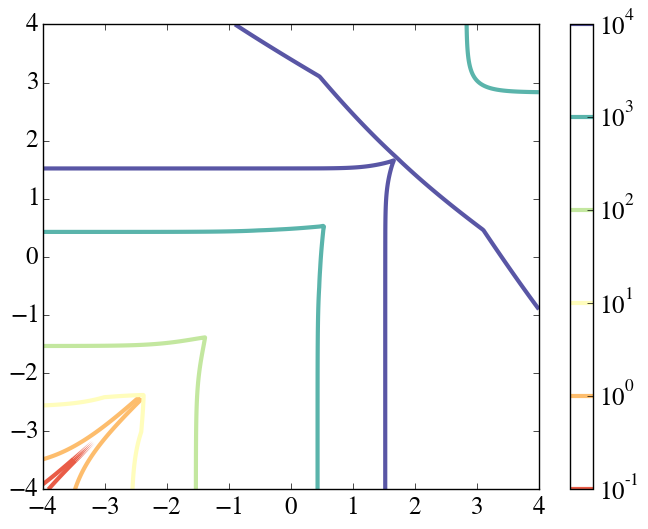

In [27]:
fig = plt.figure(1,figsize=(8,6))

R_1, R_2 = np.meshgrid(np.log10(r_1_arr),np.log10(r_2_arr))
cmap = cm.Spectral
# levels = [0.01, 0.1, 1.0, 10., 100., 1000.,5000., 6000.]

CS = plt.contour(R_1,R_2,v_12_arr,
                 norm=colors.LogNorm(vmin=1e-2, vmax=v_12_arr.max()),
                 cmap=cmap)
plt.colorbar(CS)
# plt.clabel(CS, inline=1, fontsize=10)

In [12]:
v_12_arr.max()

12111.156931285139

# Test which velocities can break the particle

In [82]:
Q_crit = 0.5*(100.)**2.

a_au = 1.
m_suns = 1.
r_1 = 10.
rho_s = 2.0
m_1 = 4./3.*np.pi*r_1**3.*rho_s

sol_gas_ratio = 100.

sig_g = 20000*(a_au)**(-1.)
sig_p = sig_g / sol_gas_ratio

T = 280*(a_au)**(-3./7.)
cs =  np.sqrt(fn.k*T/fn.mu)
print cs
vth = np.sqrt(8./np.pi)*cs
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
Hg = cs/om
rho_g = sig_g/2./Hg
mfp = fn.mu/rho_g/fn.cross

alphas = np.array([1e-4,1e-3,1e-2,1e-1])
r_2_arr = np.logspace(-2,3,num=1000)

st_1 = st_rad(rad=r_1,a_au = a_au, m_suns = m_suns)

Q_arr = np.zeros((len(alphas),len(r_2_arr)))

for i,alph in enumerate(alphas):
    Re_t = alph*cs*Hg/(vth*mfp)
    v_gas = np.sqrt(alph)*cs
    for j,r_2 in enumerate(r_2_arr):
        st_2 = st_rad(rad=r_2,a_au = a_au, m_suns = m_suns)
        v_12 = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = v_gas)
        m_2 = 4./3.*np.pi*r_2**3.*rho_s
        m_tot = m_1 + m_2
        m_red = (m_2*m_1)/m_tot
        Q_arr[i,j] = 0.5*m_red*(v_12)**2./m_tot


99192.6698433


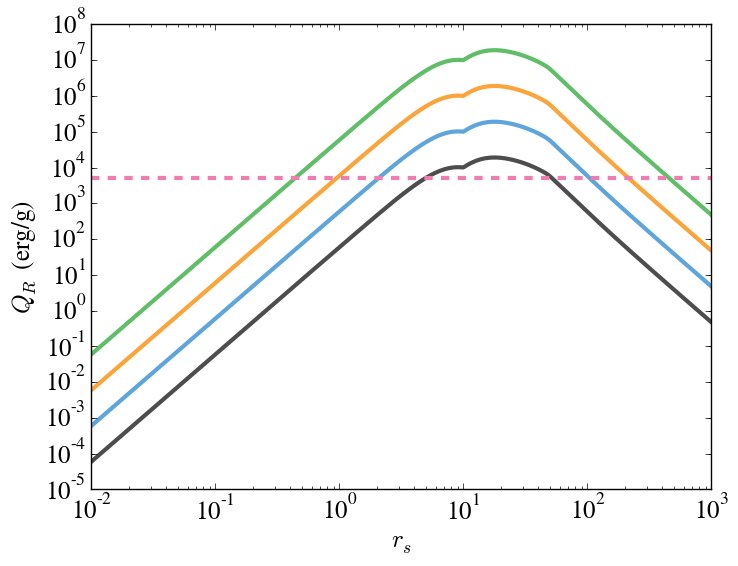

In [83]:
fig = plt.figure(1,figsize=(8,6))

for i in range(len(alphas)):
    plt.loglog(r_2_arr,Q_arr[i])
    
plt.loglog(r_2_arr,np.full(len(r_2_arr),Q_crit),linestyle='dashed')
plt.xlabel('$r_s$')
plt.ylabel('$Q_R$ (erg/g)')

In [32]:
m_suns = 1.
r_1 = 1e0
r_2 = 0.9
alpha = 1e-3

semi_majors = np.linspace(1,100,num=1000)
v_12_arr = np.zeros(len(semi_majors))
v_gas_arr = np.zeros(len(semi_majors))

for i,a_au in enumerate(semi_majors):
    st_1 = st_rad(rad=r_1,a_au = a_au, m_suns = m_suns)
    st_2 = st_rad(rad=r_2,a_au = a_au, m_suns = m_suns)
    
    sol_gas_ratio = 100.

    sig_g = 20000*(a_au)**(-1.)
    sig_p = sig_g / sol_gas_ratio

    T = 82*(a_au)**(-3./7.)
    cs =  np.sqrt(fn.k*T/fn.mu)
    vth = np.sqrt(8./np.pi)*cs
    om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
    Hg = cs/om
    rho_g = sig_g/2./Hg
    mfp = fn.mu/rho_g/fn.cross
    
    v_gas = np.sqrt(alph)*cs
    v_gas_arr[i] = v_gas

    Re_t = alph*cs*Hg/(vth*mfp)
    v_12_arr[i] = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = v_gas)

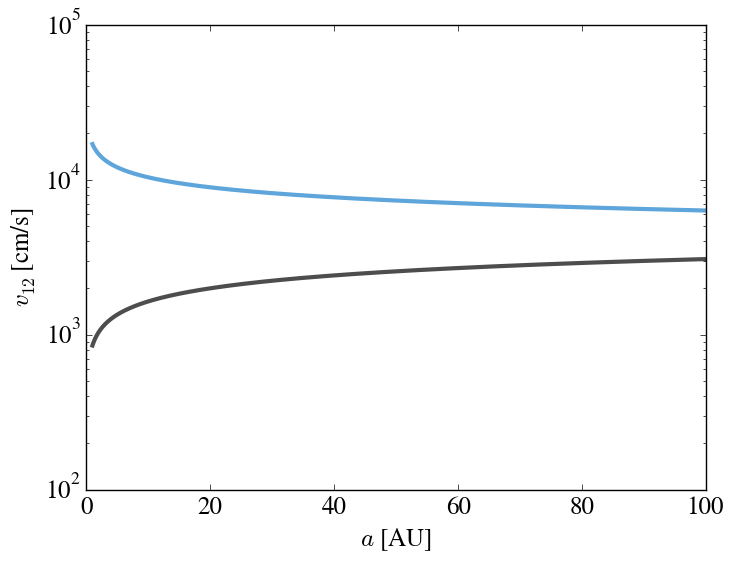

In [35]:
fig = plt.figure(1,figsize=(8,6))


plt.semilogy(semi_majors,v_12_arr)
plt.semilogy(semi_majors,v_gas_arr)

plt.xlabel('$a$ [AU]')
plt.ylabel('$v_{12}$ [cm/s]')

# Check Contour Plots from Other Papers

## Check Contour Plot from OC07

In [7]:
st_1_arr = np.logspace(-8,2,num=500)
st_2_arr = np.logspace(-8,2,num=500)

v_12_arr = np.zeros((len(st_1_arr),len(st_2_arr)))

Re_t = 1e8 #Value from paper

levels = [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1e0,0.8,1.15] #Levels are approximately equally spaced logarithmically

for i,st_1 in enumerate(st_1_arr):
    for j,st_2 in enumerate(st_2_arr): 
        v_12_arr[i,j] = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = 1.)
#         print i,j,v_12

//anaconda/lib/python2.7/site-packages/matplotlib/contour.py:1515: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


<matplotlib.colorbar.Colorbar instance at 0x111070638>

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


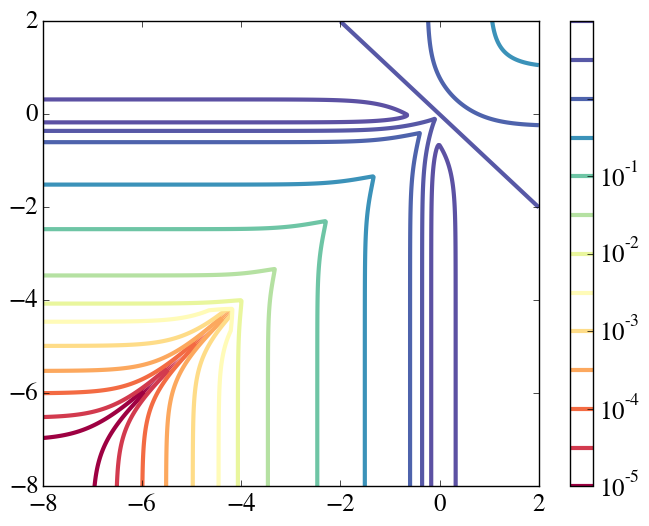

In [8]:
fig = plt.figure(1,figsize=(8,6))

R_1, R_2 = np.meshgrid(np.log10(st_1_arr),np.log10(st_2_arr))
cmap = cm.Spectral
# levels = [0.01, 0.1, 1.0, 10., 100., 1000.,5000., 6000.]

levels = [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,0.8,1e0,1.15]

CS = plt.contour(R_1,R_2,v_12_arr,
                 norm=colors.LogNorm(vmin=1e-5, vmax=v_12_arr.max()),
                 cmap=cmap,levels=levels)
plt.colorbar(CS)

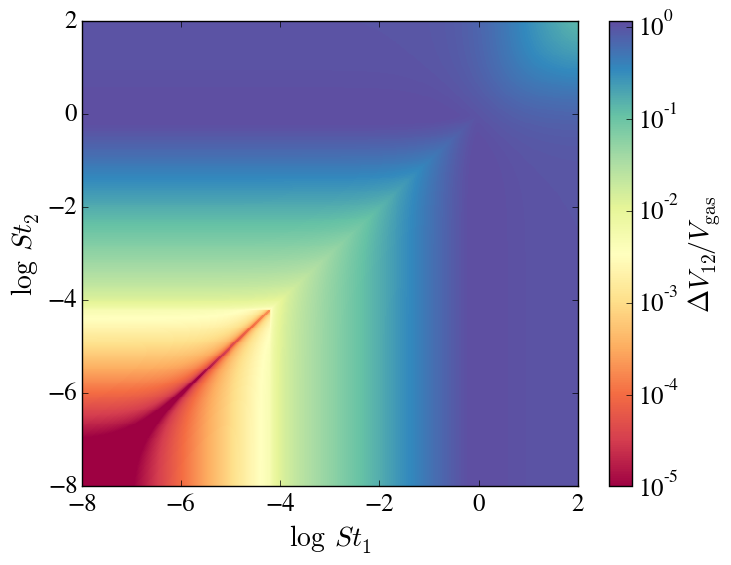

In [15]:
fig = plt.figure(1,figsize=(8,6))

im = plt.pcolormesh(R_1,R_2,v_12_arr, cmap='Spectral',norm=LogNorm(),vmin=1e-5,vmax=1.15)
cb = fig.colorbar(im)
cb.set_label(r'$\Delta V_{12}/V_{\rm{gas}}$',fontsize=20)

plt.xlabel(r'$\log \, St_1$',fontsize=20)
plt.ylabel(r'$\log \, St_2$',fontsize=20)

In [19]:
fig.savefig('OC07_V12.png',dpi=500)

## Try to reproduce Weidenschilling and Cuzzi Laminar Case

In [22]:
d_1_arr = np.logspace(-4,4,num=1000)
d_2_arr = np.logspace(-4,4,num=1000)

st_1_arr = np.zeros(len(d_1_arr))
st_2_arr = np.zeros(len(d_2_arr))

d_v_lam_arr = np.zeros((len(d_1_arr),len(d_2_arr)))


k = 1.381e-16
T = 280.
eta_vk = 5400. #\Delta_V from paper
a_au = 1.
m_suns = 1.
cs = np.sqrt(k*T/fn.mu)
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
Hg = cs/om
rho_g = 1.4e-9 #Gas density from paper
sig_g = 2*rho_g*Hg #Back out surface density from gas density


rho_s = 2.

st_1_arr = [st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_1 in d_1_arr]
st_2_arr = [st_rad(rad=d_2/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_2 in d_2_arr]

for i,d_1 in enumerate(d_1_arr):
    for j,d_2 in enumerate(d_2_arr):
        
        st_1 = st_1_arr[i]
        st_2 = st_2_arr[j]
        
        mu_1 = 4./3.*np.pi*(d_1/2.)**3.*rho_s #Masses of the small bodies, assuming uniform density spheres
        mu_2 = 4./3.*np.pi*(d_2/2.)**3.*rho_s 
        
        mu_red = mu_1*mu_2/(mu_1 + mu_2) #Reduced mass
        
        v_th = np.sqrt(8.*k*T/np.pi/mu_red) #Relative thermal velocity between two small bodies is the small as 
                                            #velocity of one body of mass equal to their reduced mass
            
        """Other ways I tried of calculating the velocity"""
        
#         v_th_1 = np.sqrt(8.*k*T/np.pi/mu_1)
#         v_th_2 = np.sqrt(8.*k*T/np.pi/mu_2)
        
#         v_th_1 = np.sqrt(3.*k*T/mu_1)
#         v_th_2 = np.sqrt(3.*k*T/mu_2)
        
#         v_th = np.sqrt(3.*k*T/mu_red)
#         
#         v_th = max(v_th_1,v_th_2)
#         v_th = v_th_1 + v_th_2
#         v_th = np.sqrt(v_th_1**2 + v_th_2**2)
#         st_2 = d_2*rho_s/(2.*rho_g*cs)*om
        
        #Laminar velocity of each particle in the r_hat direction
        v_r_1 = -2.*eta_vk*(st_1/(1+st_1**2.))
        v_r_2 = -2.*eta_vk*(st_2/(1+st_2**2.))
        d_v_r = np.abs(v_r_1 - v_r_2)
        
        #Laminar velocity of each particle in the theta_hat direction
        v_theta_1 = -eta_vk*(1./(1+st_1**2.))
        v_theta_2 = -eta_vk*(1./(1+st_2**2.))
        d_v_theta = np.abs(v_theta_1 - v_theta_2)

#         d_v_theta = 0
        
#         d_v_lam = d_v_r + d_v_theta
        d_v_lam = np.sqrt(d_v_r**2. + d_v_theta**2.) #Total laminar velocity
        
        d_v_tot = np.sqrt(v_th**2. + d_v_lam**2.) #Not really sure how these velocities combine - added them in quadrature
#         d_v_tot = v_th + d_v_lam
#         d_v_tot = max(v_th,d_v_lam)
        
        d_v_lam_arr[i,j] = d_v_tot
        

<matplotlib.colorbar.Colorbar instance at 0x1191f0878>

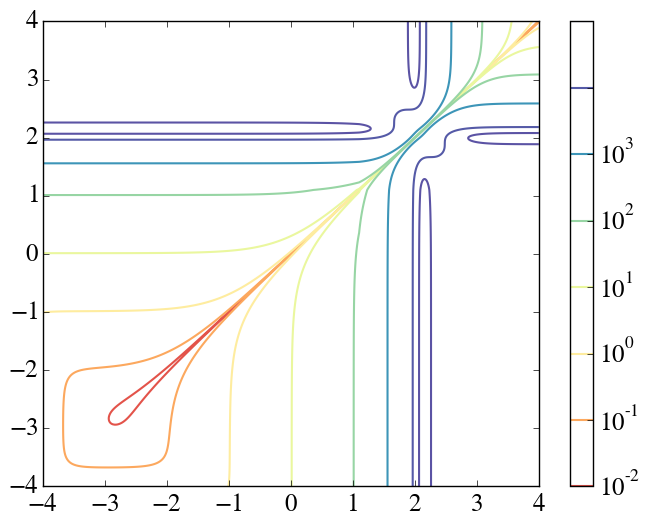

In [10]:
fig = plt.figure(1,figsize=(8,6))

plt.rc('lines', linewidth=1.5)

D_1, D_2 = np.meshgrid(np.log10(d_1_arr),np.log10(d_2_arr))
ST_1, ST_2 = np.meshgrid(np.log10(st_1_arr),np.log10(st_2_arr))

cmap = cm.Spectral
levels = [0.01, 0.1, 1.0, 10., 100., 1000.,5000.,6000.]

# levels = [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,0.8,1e0,1.15]

CS = plt.contour(D_1,D_2,d_v_lam_arr,
                 norm=colors.LogNorm(vmin=1e-3, vmax=7000.),
                 cmap=cmap,levels=levels)

plt.colorbar(CS)

<matplotlib.colorbar.Colorbar instance at 0x12ae5c998>

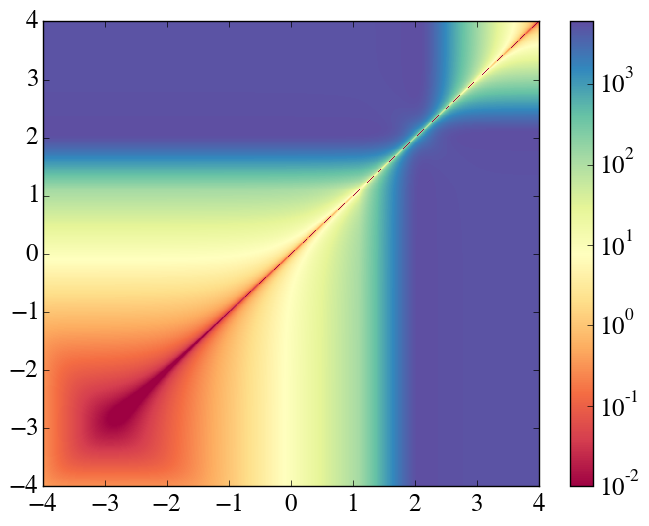

In [15]:
fig = plt.figure(1,figsize=(8,6))

im = plt.pcolormesh(D_1,D_2,d_v_lam_arr, cmap='Spectral',norm=LogNorm(),vmin=1e-2,vmax=6000)
fig.colorbar(im)

## Add Turbulence

In [30]:
"""Code here is indentical to the laminar case, except that a turbulent term is computed and added in quadrature
to the other two velocity terms"""

d_1_arr = np.logspace(-4,4,num=1000)
d_2_arr = np.logspace(-4,4,num=1000)

st_1_arr = np.zeros(len(d_1_arr))
st_2_arr = np.zeros(len(d_2_arr))

d_v_arr = np.zeros((len(d_1_arr),len(d_2_arr)))


k = 1.381e-16
T = 280.
eta_vk = 5400.
a_au = 1.
m_suns = 1.
cs = np.sqrt(k*T/fn.mu)
Hg = cs/om
rho_g = 1.4e-9 #Gas density from paper
sig_g = 2*rho_g*Hg #Back out surface density from gas density
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)

v_gas_turb = 1000.
alpha = v_gas_turb/cs
vth = np.sqrt(8./np.pi)*cs
mfp = fn.mu/rho_g/fn.cross

Re_t = alpha*cs*Hg/vth/mfp

rho_s = 2.

st_1_arr = [st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_1 in d_1_arr]
st_2_arr = [st_rad(rad=d_2/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_2 in d_2_arr]

for i,d_1 in enumerate(d_1_arr):
    
    if i%10 ==0:
        print i
    
    for j,d_2 in enumerate(d_2_arr):
        
        st_1 = st_1_arr[i]
        st_2 = st_2_arr[j]
        
        mu_1 = 4./3.*np.pi*(d_1/2.)**3.*rho_s
        mu_2 = 4./3.*np.pi*(d_2/2.)**3.*rho_s
        
        mu_red = (mu_1*mu_2)/(mu_1 + mu_2)
        
#         v_th_1 = np.sqrt(8.*k*T/np.pi/mu_1)
#         v_th_2 = np.sqrt(8.*k*T/np.pi/mu_2)
        
#         v_th_1 = np.sqrt(3.*k*T/mu_1)
#         v_th_2 = np.sqrt(3.*k*T/mu_2)
        
#         v_th = max(v_th_1,v_th_2)
        v_th = np.sqrt(8.*k*T/np.pi/mu_red)
        
#         st_2 = d_2*rho_s/(2.*rho_g*cs)*om
        
        v_r_1 = -2*eta_vk*(st_1/(1+st_1**2.))
        v_r_2 = -2*eta_vk*(st_2/(1+st_2**2.))
        d_v_r = np.abs(v_r_1 - v_r_2)
        
        v_theta_1 = -eta_vk*(1./(1+st_1**2.))
        v_theta_2 = -eta_vk*(1./(1+st_2**2.))
        d_v_theta = np.abs(v_theta_1 - v_theta_2)
        
        v_turb = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = v_gas_turb) #Added in line for turbulence

#         d_v_theta = 0
        
#         d_v_lam = d_v_r + d_v_theta
        d_v_lam = np.sqrt(d_v_r**2. + d_v_theta**2.)
        
        d_v_tot = np.sqrt(v_th**2. + d_v_lam**2. + v_turb**2.) #Add all velocities in quadrature
#         d_v_tot = v_th + d_v_lam
#         d_v_tot = max(v_th,d_v_lam)
        
        d_v_arr[i,j] = d_v_tot
        

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


<matplotlib.colorbar.Colorbar instance at 0x1a90ad908>

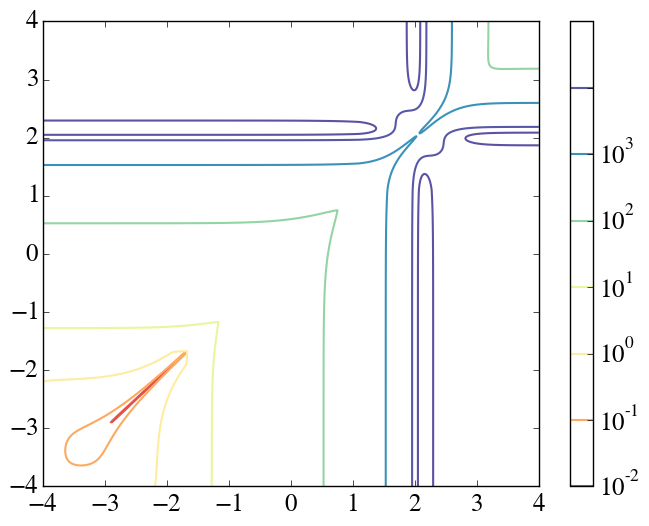

In [32]:
fig = plt.figure(1,figsize=(8,6))

plt.rc('lines', linewidth=1.5)

D_1, D_2 = np.meshgrid(np.log10(d_1_arr),np.log10(d_2_arr))
ST_1, ST_2 = np.meshgrid(np.log10(st_1_arr),np.log10(st_2_arr))

cmap = cm.Spectral
levels = [0.01, 0.1, 1.0, 10., 100., 1000.,5000.,6000.]

# levels = [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,0.8,1e0,1.15]

CS = plt.contour(D_1,D_2,d_v_arr,
                 norm=colors.LogNorm(vmin=1e-3, vmax=6500.),
                 cmap=cmap,levels=levels)

# CS = plt.contour(D_1,D_2,np.log10(d_v_arr),
#                  cmap=cmap,levels=levels)

plt.colorbar(CS)

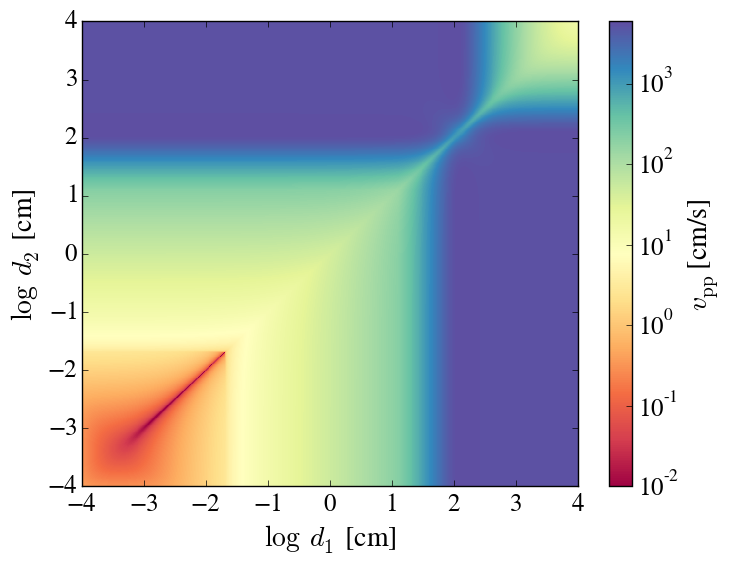

In [36]:
fig = plt.figure(1,figsize=(8,6))

im = plt.pcolormesh(D_1,D_2,d_v_arr, cmap='Spectral',norm=LogNorm(),vmin=1e-2,vmax=6000)

cb = fig.colorbar(im)
cb.set_label(r'$v_{\rm{pp}}$ [cm/s]',fontsize=20)
plt.xlabel(r'$\log \, d_1$ [cm]',fontsize=20)
plt.ylabel(r'$\log \, d_2$ [cm]',fontsize=20)

In [37]:
fig.savefig('../../UCSC_Qual/v_pp_full.png',dpi=500)

# Fin

NameError: name 'd_v_sng_arr' is not defined

In [33]:
d_1_arr = np.logspace(-4,6,num=1000)
d_2 = 1e-4

st_1_arr = np.zeros(len(d_1_arr))

k = 1.381e-16
T = 280.
eta_vk = 5400.
a_au = 1.
m_suns = 1.
cs = np.sqrt(k*T/fn.mu)
rho_g = 1.4e-9
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)

Re_t_arr = [1e4,1e6,1e8,Re_t,1e10]
# Re_t_arr = [Re_t]
d_v_sng_arr = np.zeros((len(Re_t_arr),len(d_1_arr)))

rho_s = 2.

st_1_arr = [st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns) for d_1 in d_1_arr]
st_2 = st_rad(rad=d_2/2.,a_au = a_au, m_suns = m_suns)

for i,Re_t in enumerate(Re_t_arr):
    for j,d_1 in enumerate(d_1_arr):
        st_1 = st_1_arr[j]



        v_turb = d_V_12(st_1 = st_1, st_2 = st_2, Re = Re_t, v_gas = 1000.)

    #         d_v_theta = 0

    #         d_v_lam = d_v_r + d_v_theta


        d_v_sng_arr[i,j] = v_turb
        

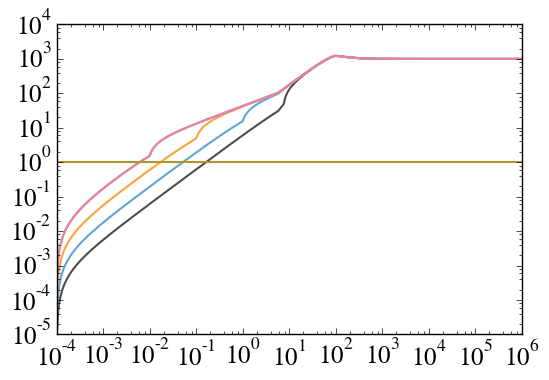

In [34]:
for i in range(len(Re_t_arr)):
    plt.loglog(d_1_arr,d_v_sng_arr[i])
plt.loglog(d_1_arr,np.full(len(d_1_arr),1e0))

In [45]:
st_1_bad = [st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns) for d_1 in d_1_arr]
st_1_corr = [st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_1 in d_1_arr]

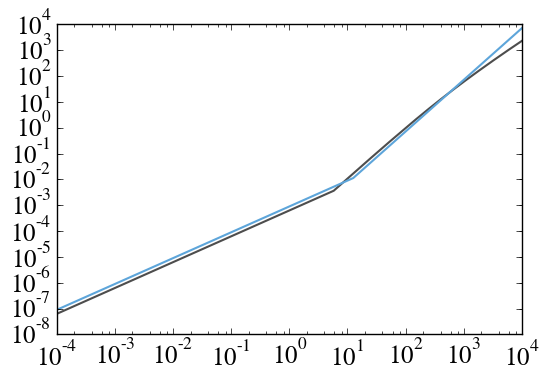

In [46]:
plt.loglog(d_1_arr,st_1_bad)
plt.loglog(d_1_arr,st_1_corr)

In [47]:
alpha = (1000./cs)
Hg = cs/om
vth = np.sqrt(8./np.pi)*cs
mfp = fn.mu/rho_g/fn.cross

Re = alpha*cs*Hg/vth/mfp

print "%.3g" %Re


1.12e+09


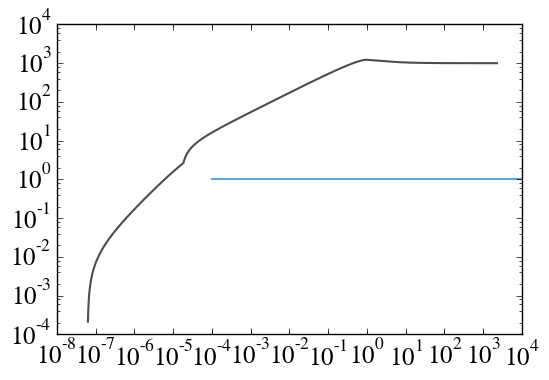

In [56]:
for i in range(len(Re_t_arr)):
    plt.loglog(st_1_arr,d_v_sng_arr[i])
plt.loglog(d_1_arr,np.full(len(d_1_arr),1e0))

In [20]:
sig_g

1394.9228924691427

In [21]:
print "%.5g" %Re_t

1.1212e+09


In [6]:
a_au = 1.
m_suns = 1.

d_1_arr = np.logspace(-4,4,num=1000)


# d_2_arr = np.logspace(0.8,1.6,num=10)
d_2_arr = [1e-4]
st_2_arr = [st_rad(rad=d_2/2.,a_au = a_au, m_suns = m_suns) for d_2 in d_2_arr]

# d_2_arr = np.logspace(-4,4,num=1000)

d_v_sng_arr = np.zeros((len(d_2_arr),len(d_1_arr)))


k = 1.381e-16
T = 280.
eta_vk = 5400.
a_au = 1.
m_suns = 1.
cs = np.sqrt(k*T/fn.mu)
rho_g = 1.4e-9
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)

rho_s = 2.

for i,d_2 in enumerate(d_2_arr): 
    for j,d_1 in enumerate(d_1_arr):
        
        st_1 = st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns)
        st_2 = st_2_arr[i]

        v_r_1 = -2*eta_vk*(st_1/(1+st_1**2.))
        v_r_2 = -2*eta_vk*(st_2/(1+st_2**2.))
        d_v_r = v_r_1 - v_r_2

        v_theta_1 = -eta_vk*(1/(1+st_1**2.))
        v_theta_2 = -eta_vk*(1/(1+st_2**2.))
        d_v_theta = v_theta_1 - v_theta_2

        d_v_lam = np.sqrt(d_v_r**2. + d_v_theta**2.)
        d_v_sng_arr[i,j] = d_v_lam
        

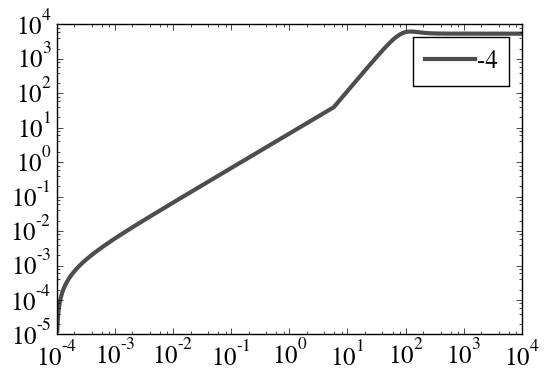

In [7]:
for i in range(len(d_2_arr)):
    plt.loglog(d_1_arr,d_v_sng_arr[i],label="%.3g" %(np.log10(d_2_arr[i])))
ax = plt.gca()
ax.legend(loc='best')

In [12]:
d_1_arr = np.logspace(-4,4,num=1000)
d_2_arr = np.logspace(-4,4,num=1000)

st_1_arr = np.zeros(len(d_1_arr))
st_2_arr = np.zeros(len(d_2_arr))

d_v_lam_arr = np.zeros((len(d_1_arr),len(d_2_arr)))


k = 1.381e-16
T = 280.
eta_vk = 5400. #\Delta_V from paper
a_au = 1.
m_suns = 1.
cs = np.sqrt(k*T/fn.mu)
Hg = cs/om
rho_g = 1.4e-9 #Gas density from paper
sig_g = 2*rho_g*Hg #Back out surface density from gas density
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)

rho_s = 2.

st_1_arr = [st_rad(rad=d_1/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_1 in d_1_arr]
st_2_arr = [st_rad(rad=d_2/2.,a_au = a_au, m_suns = m_suns, temp_in= T, sig_in= sig_g,no_ram=1) for d_2 in d_2_arr]

for i,d_1 in enumerate(d_1_arr):
    for j,d_2 in enumerate(d_2_arr):
        
        st_1 = st_1_arr[i]
        st_2 = st_2_arr[j]
        
        mu_1 = 4./3.*np.pi*(d_1/2.)**3.*rho_s #Masses of the small bodies, assuming uniform density spheres
        mu_2 = 4./3.*np.pi*(d_2/2.)**3.*rho_s 
        
        mu_red = mu_1*mu_2/(mu_1 + mu_2) #Reduced mass
        
        v_th = np.sqrt(8.*k*T/np.pi/mu_red) #Relative thermal velocity between two small bodies is the small as 
                                            #velocity of one body of mass equal to their reduced mass
            
        """Other ways I tried of calculating the velocity"""
        
#         v_th_1 = np.sqrt(8.*k*T/np.pi/mu_1)
#         v_th_2 = np.sqrt(8.*k*T/np.pi/mu_2)
        
#         v_th_1 = np.sqrt(3.*k*T/mu_1)
#         v_th_2 = np.sqrt(3.*k*T/mu_2)
        
#         v_th = np.sqrt(3.*k*T/mu_red)
#         
#         v_th = max(v_th_1,v_th_2)
#         v_th = v_th_1 + v_th_2
#         v_th = np.sqrt(v_th_1**2 + v_th_2**2)
#         st_2 = d_2*rho_s/(2.*rho_g*cs)*om
        
        #Laminar velocity of each particle in the r_hat direction
     
        d_v_lam = 0 
        d_v_tot = np.sqrt(v_th**2. + d_v_lam**2.) #Not really sure how these velocities combine - added them in quadrature
#         d_v_tot = v_th + d_v_lam
#         d_v_tot = max(v_th,d_v_lam)
        
        d_v_lam_arr[i,j] = d_v_tot
        

<matplotlib.colorbar.Colorbar instance at 0x1171a5cf8>

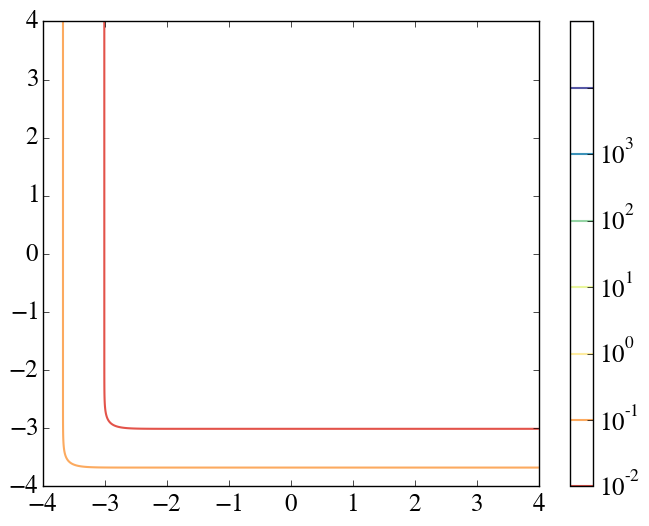

In [13]:
fig = plt.figure(1,figsize=(8,6))

plt.rc('lines', linewidth=1.5)

D_1, D_2 = np.meshgrid(np.log10(d_1_arr),np.log10(d_2_arr))
ST_1, ST_2 = np.meshgrid(np.log10(st_1_arr),np.log10(st_2_arr))

cmap = cm.Spectral
levels = [0.01, 0.1, 1.0, 10., 100., 1000.,5000.,6000.]

# levels = [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,0.8,1e0,1.15]

CS = plt.contour(D_1,D_2,d_v_lam_arr,
                 norm=colors.LogNorm(vmin=1e-3, vmax=6500.),
                 cmap=cmap,levels=levels)

# CS = plt.contour(D_1,D_2,np.log10(d_v_arr),
#                  cmap=cmap,levels=levels)

plt.colorbar(CS)

In [6]:
k = 1.381e-16
T = 120.
# eta_vk = 5400. #\Delta_V from paper
a_au = 1.
a_cgs = a_au*fn.au

m_suns = 1.
m_star = m_suns*fn.m_sun

m_earths = 1.
m_p = m_earths*fn.m_earth
r_p = 1.*fn.r_earth

r_hill = a_cgs*(m_p/3./m_star)**(1./3.)
p = r_p/r_hill

cs = np.sqrt(k*T/fn.mu)
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
Hg = cs/om
# rho_g = 1.4e-9 #Gas density from paper
sig_g = 2000*a_au**(-1.) #Back out surface density from gas density
sol_gas_ratio = 100.
sig_p = sig_g/sol_gas_ratio

rho_s = 2.

t_GF = m_p/(sig_p*om*p*r_hill**2.)*fn.sec_to_years/2.
print "t_GF = %.3g" %t_GF


t_GF = 2.49e+05


In [11]:
(2.5e6/1.13e5)**3./(10.**(9./2.))

0.34244016336669164

# Let's Calculate Some Destruction Timescales

In [9]:
a_au_arr = np.linspace(1,100,num=1000)
alpha_arr = [1e-4,1e-3,1e-2,1e-1]
v_pp_arr = np.zeros((len(alpha_arr),len(a_au_arr)))
Q_arr = np.zeros((len(alpha_arr),len(a_au_arr)))

st_1 = 1.
st_2 = 1.

v_crit = 100.
Q_crit = 0.5*(1000.)**2.

rho_s = 2.
T_0 = 270.
sig_0 = 2e5

for i,alpha in enumerate(alpha_arr):
    for j,a_au in enumerate(a_au_arr):
        v_pp_tmp = v_pp(st_1 = st_1, st_2 = st_2, a_au=a_au, alpha=alpha, T_0=T_0, sig_0=sig_0)
        v_pp_arr[i,j] = v_pp_tmp

        T = T_0*(a_au)**(-3./7.)
        sig = sig_0*(a_au)**(-1.)

        r_1 = st_solver(st = st_1,a_au = a_au, sig_in = sig, temp_in = T)
        r_2 = st_solver(st = st_2,a_au = a_au, sig_in = sig, temp_in = T)

        m_1 = 4./3.*np.pi*r_1**3.*rho_s
        m_2 = 4./3.*np.pi*r_2**3.*rho_s

        m_tot = m_1 + m_2
        m_red = (m_2*m_1)/m_tot
        Q_arr[i,j] = 0.5*m_red*(v_pp_tmp)**2./m_tot

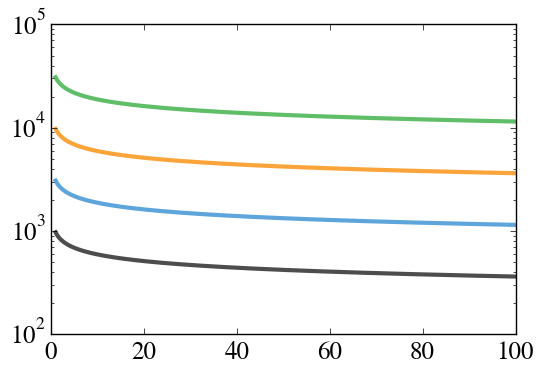

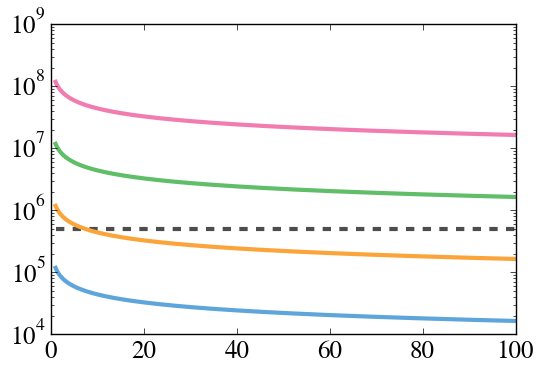

In [10]:
plt.figure(1)

for i in range(len(alpha_arr)):
    plt.semilogy(a_au_arr,v_pp_arr[i])
    
plt.figure(2)
plt.semilogy(a_au_arr,np.full(len(a_au_arr),Q_crit),linestyle='dashed')
for i in range(len(alpha_arr)):
    plt.semilogy(a_au_arr,Q_arr[i])

## Growth Timescale vs. Drift Timescale

In [11]:
a_au_arr = np.linspace(1,100,num=1000)
alpha_arr = [1e-4,1e-3,1e-2,1e-1]
v_pp_arr = np.zeros((len(alpha_arr),len(a_au_arr)))
Q_arr = np.zeros((len(alpha_arr),len(a_au_arr)))

st_1 = 1.
st_2 = 1.

v_crit = 100.
Q_crit = 0.5*(1000.)**2.

rho_s = 2.

for i,alpha in enumerate(alpha_arr):
    for j,a_au in enumerate(a_au_arr):
        v_pp_tmp = v_pp(st_1 = st_1, st_2 = st_2, a_au=a_au,alpha=alpha)
        v_pp_arr[i,j] = v_pp_tmp

        T = 270*(a_au)**(-3./7.)
        sig = 2e6*(a_au)**(-1.)

        r_1 = st_solver(st = st_1,a_au = a_au, sig_in = sig, temp_in = T)
        r_2 = st_solver(st = st_2,a_au = a_au, sig_in = sig, temp_in = T)

        m_1 = 4./3.*np.pi*r_1**3.*rho_s
        m_2 = 4./3.*np.pi*r_2**3.*rho_s

        m_tot = m_1 + m_2
        m_red = (m_2*m_1)/m_tot
        Q_arr[i,j] = 0.5*m_red*(v_pp_tmp)**2./m_tot

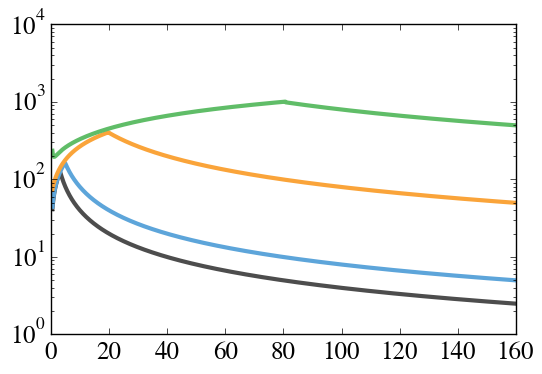

In [14]:
a_au_arr = np.linspace(0.5,160,num=1000)

sig_0_arr = [1e3,2e3,2e4,2e5]
st_arr = np.zeros((len(sig_0_arr),len(a_au_arr)))

T_0 = 270.

for i,sig_0 in enumerate(sig_0_arr):
    for j,a_au in enumerate(a_au_arr):
        T = T_0*a_au**(-3./7.)
        sig = sig_0*a_au**(-1.)
        st_arr[i,j] = st_solver(st=1,a_au = a_au, temp_in = T, sig_in = sig)

for i in range(len(sig_0_arr)):
    plt.semilogy(a_au_arr,st_arr[i])

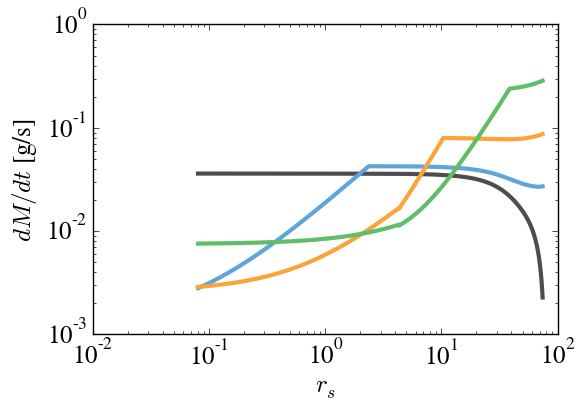

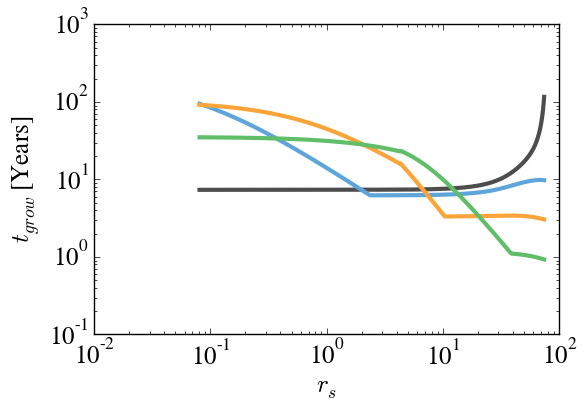

In [61]:
alpha_arr = [1e-100,1e-4,1e-3,1e-2]
r_fixed = 100.

a_au = 1.
a_cgs = a_au*fn.au

m_suns = 1.
m_star = m_suns*fn.m_sun

T_0 = 270.
T_exp = -3./7.
T = T_0*a_au**T_exp

cs = np.sqrt(fn.k*T/fn.mu)
om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3)
H_g = cs/om

sig_0 = 2000.
sig_exp = -1.
sig_g = sig_0*a_au**sig_exp #Back out surface density from gas density
sol_gas_ratio = 100.
sig_p = sig_g/sol_gas_ratio

rho_s = 2.

st_fixed = st_rad(rad=r_fixed,alph = alpha,a_au=a_au,m_suns=m_suns,sig_in = sig_g,temp_in = T)
m_fixed = 4./3.*np.pi*r_fixed**3.*rho_s

st_min = 1e-4
st_max = 1.

r_min = st_solver(st=st_min,alph = alpha,a_au=a_au,m_suns=m_suns,sig_in = sig_g,temp_in = T)
r_max = st_solver(st=st_max,alph = alpha,a_au=a_au,m_suns=m_suns,sig_in = sig_g,temp_in = T)

r_arr = np.logspace(np.log10(r_min*1.01),np.log10(r_max),num=1000)
t_coll_arr = np.zeros((len(alpha_arr),len(r_arr)))
rate_arr = np.zeros((len(alpha_arr),len(r_arr)))

for i,alpha in enumerate(alpha_arr):
    for j,r_s in enumerate(r_arr):
        st_int = st_rad(rad=r_s,alph = alpha,a_au=a_au,m_suns=m_suns,sig_in = sig_g,temp_in = T)
        m_int = 4./3.*np.pi*r_s**3.*rho_s

        H_p_turb = (alpha/(alpha+st_int))*H_g
        H_p_lam = H_g**2/a_cgs
        H_p = max(H_p_turb,H_p_lam)
        n = sig_p/2./H_p/m_int

        sigma = np.pi*(r_s**2. + r_fixed**2.)
        v_rel = v_pp(st_1 = st_fixed, st_2 = st_int, alpha = alpha, a_au = a_au, m_suns = m_suns,\
                     T_0 = T_0, T_exp = T_exp, sig_0 = sig_0,sig_exp = sig_exp, sol_gas_ratio = sol_gas_ratio)

        dM_dt = n*sigma*v_rel*m_int
        rate_arr[i,j] = dM_dt
        t_coll_arr[i,j] = m_fixed/dM_dt*fn.sec_to_years

plt.figure(1)

for i in range(len(alpha_arr)):
    plt.loglog(r_arr,rate_arr[i])
plt.xlabel(r"$r_s$")
plt.ylabel(r"$dM/dt$ [g/s]")    

plt.figure(2)

for i in range(len(alpha_arr)):
    plt.loglog(r_arr,t_coll_arr[i])
plt.xlabel(r"$r_s$")
plt.ylabel(r"$t_{grow}$ [Years]")

In [65]:
alpha_arr = [1e-100,1e-4,1e-3,1e-2]
rate_arr = []

for alpha in alpha_arr:
    t,rate_tmp= t_coll_int(r_s=100.,alpha=alpha,out='arr')
    rate_arr.append(rate_tmp)
    
    print "time = %.4g" %t
    print "rate = %.4g\n" %np.sum(rate_tmp)

time = 8.86
rate = 0.02996

time = 7.579
rate = 0.03503

time = 4.539
rate = 0.05849

time = 2.494
rate = 0.1064



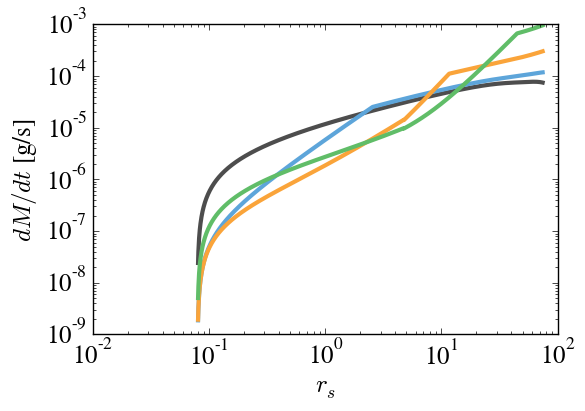

In [66]:
for i in range(len(alpha_arr)):
    plt.loglog(r_arr,rate_arr[i])
plt.xlabel(r"$r_s$")
plt.ylabel(r"$dM/dt$ [g/s]")

In [70]:
alpha = 1e-2
cs = (fn.k*(270*100**(-3./7.))/fn.mu)**(0.5)
om = 2*np.pi/3.15e7*(100**(-3./2.))
H_g = cs/om
sig_p = 20.*100**(-1.)

v = v_pp(st_1 = 1., st_2 = 1., alpha = alpha, a_au = 100.)
H_p = max(alpha/(alpha+1.)**(0.5)*H_g,H_g**2/fn.au)
sigma = np.pi*(100**2. + 100**2.)
rho_p = sig_p/2./H_p
dM_dt = v*sigma*rho_p

print "v = %.4g" %v
print "H_p = %.4g" %H_p
print "rho_p = %.4g" %rho_p
print "dM_dt = %.4g" %dM_dt

v = 3631
H_p = 2.215e+15
rho_p = 4.515e-17
dM_dt = 1.03e-08
